In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
df = pd.read_parquet('data/df_v2.pqt')

In [3]:
df['V3_confidentialityImpact'].value_counts(), df['V3_integrityImpact'].value_counts(), df['V3_availabilityImpact'].value_counts()

(HIGH    46146
 NONE    17015
 LOW     15103
 Name: V3_confidentialityImpact, dtype: int64,
 HIGH    40105
 NONE    24400
 LOW     13759
 Name: V3_integrityImpact, dtype: int64,
 HIGH    45795
 NONE    30415
 LOW      2054
 Name: V3_availabilityImpact, dtype: int64)

In [4]:
outcomes = ['V3_confidentialityImpact', 'V3_integrityImpact', 'V3_availabilityImpact']

### The outcomes have three possible values

In [5]:
df.select_dtypes(['object']).columns

Index(['cve_id', 'V2_severity', 'V2_userInteractionRequired', 'V2_version',
       'V2_vectorString', 'V2_accessVector', 'V2_accessComplexity',
       'V2_authentication', 'V2_confidentialityImpact', 'V2_integrityImpact',
       'V2_availabilityImpact', 'V2_acInsufInfo', 'V3_version',
       'V3_vectorString', 'V3_attackVector', 'V3_attackComplexity',
       'V3_privilegesRequired', 'V3_userInteraction', 'V3_scope',
       'V3_confidentialityImpact', 'V3_integrityImpact',
       'V3_availabilityImpact', 'V3_baseSeverity'],
      dtype='object')

### This means that in order to predict, we cannot use the V3 columns, since they will not be defined for the predictions

In [6]:
# only get V2 columns, plus id and target
# also remove V2_vectorString, since it is an aggregate of other values and has a high cardinality
valid_cols = ['cve_id'] + outcomes + [col for col in df.columns if col.startswith('V2_') and col != 'V2_vectorString']
rows_to_drop = df['V3_scope'].isna()
df = df[valid_cols]

In [7]:
string_columns = ['V2_severity', 'V2_userInteractionRequired', 'V2_version',
       'V2_accessVector', 'V2_accessComplexity', # 'V2_vectorString', 
       'V2_authentication', 'V2_confidentialityImpact', 'V2_integrityImpact',
       'V2_availabilityImpact', 'V2_acInsufInfo'] + outcomes


# We convert strings to categorical and then numeric in case we want to use numerical methods
cats = df.loc[:, string_columns].astype('category')
df.loc[:, string_columns] = cats.apply(lambda col: col.cat.codes)

In [8]:
# We only process those that are valid for training
print(df.shape)
df_to_predict = df[rows_to_drop]
df = df[~rows_to_drop]
print(df.shape)

(151637, 20)
(78264, 20)


In [9]:
df.dtypes

cve_id                         object
V3_confidentialityImpact         int8
V3_integrityImpact               int8
V3_availabilityImpact            int8
V2_severity                      int8
V2_exploitabilityScore        float64
V2_impactScore                float64
V2_obtainAllPrivilege            bool
V2_obtainUserPrivilege           bool
V2_obtainOtherPrivilege          bool
V2_userInteractionRequired       int8
V2_version                       int8
V2_accessVector                  int8
V2_accessComplexity              int8
V2_authentication                int8
V2_confidentialityImpact         int8
V2_integrityImpact               int8
V2_availabilityImpact            int8
V2_baseScore                  float64
V2_acInsufInfo                   int8
dtype: object

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

In [11]:
X = df.drop(columns=['cve_id'] + outcomes)

for outcome in outcomes:
    y = df[outcome]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    X_train.shape

    rf = RandomForestClassifier(n_estimators=200, n_jobs=-1)

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    print(outcome, balanced_accuracy_score(y_true=y_test, y_pred=y_pred))    
    print(matrix)

V3_confidentialityImpact 0.8532424868953625
[[13612   245    24]
 [ 1453  2891    68]
 [    6   389  4792]]
V3_integrityImpact 0.9082588648701723
[[11330   375   377]
 [  849  3186     9]
 [    5     1  7348]]
V3_availabilityImpact 0.6684274884201025
[[13177    57   503]
 [  517    33    51]
 [   74     7  9061]]


## Both confidentiality and integrity perform decently, but availability is not able to distinguish properly
#### Balancing the classes should help in this regard

In [12]:
X = df.drop(columns=['cve_id'] + outcomes)

for outcome in outcomes:
    y = df[outcome]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    X_train.shape

    rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight='balanced')

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    print(outcome, balanced_accuracy_score(y_true=y_test, y_pred=y_pred))    
    print(matrix)

V3_confidentialityImpact 0.872871830444887
[[11699  2157    25]
 [  586  3758    68]
 [    3   391  4793]]
V3_integrityImpact 0.921614164405674
[[10455  1250   377]
 [  393  3642     9]
 [    2     6  7346]]
V3_availabilityImpact 0.8146892284619476
[[8976 4344  417]
 [ 101  488   12]
 [  34  161 8947]]


In [13]:
# To check overfitting
y_pred_train = rf.predict(X_train)
balanced_accuracy_score(y_true=y_train, y_pred=y_pred_train)

0.820516095772581

## We repeat the experiment to be certain that the sampling did not play a part

In [14]:
n_reps = 30

balanced_accuracies = {}
X = df.drop(columns=['cve_id'] + outcomes)

rfs = {}

for outcome in outcomes:

    balanced_accuracies[outcome] = []
    y = df[outcome]
    
    for rep in tqdm(range(n_reps)):
    

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight='balanced')

        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_test)

        matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

        balanced_accuracies[outcome].append(balanced_accuracy_score(y_true=y_test, y_pred=y_pred))
        
    rfs[outcome] = rf

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Text(0.5, 0, 'Outcome')

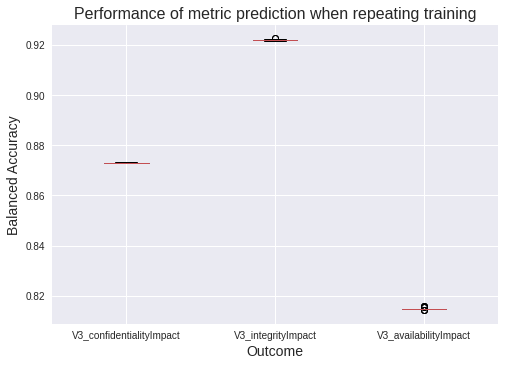

In [21]:
plt.style.use('seaborn')
df_accs = pd.DataFrame(balanced_accuracies)
df_accs.boxplot()
plt.title('Performance of metric prediction when repeating training', fontsize=16)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xlabel('Outcome', fontsize=14)
# plt.hist(balanced_accuracies)

We obtain decent balanced accuracies, with little overfitting, so the average expected recall per class should be over 80% for each of the three outcomes.

As linear models did not outperform the random forest for the scope outcome, it was not tried for these outcomes

In [16]:
X_to_predict = df_to_predict.drop(columns=['cve_id'] + outcomes)
results = df_to_predict[['cve_id']].copy()

for outcome in outcomes:
    # The predictions for the missing data are:
    y_expected = rfs[outcome].predict(X_to_predict)
    
    results[outcome] = cats[outcome].cat.categories[y_expected]

In [18]:
results

,cve_id,V3_confidentialityImpact,V3_integrityImpact,V3_availabilityImpact
0,CVE-2011-0001,NONE,NONE,LOW
1,CVE-2011-0002,LOW,LOW,NONE
2,CVE-2011-0003,LOW,LOW,NONE
3,CVE-2011-0004,LOW,LOW,NONE
4,CVE-2011-0005,LOW,LOW,NONE
...,...,...,...,...
151617,CVE-2009-5138,LOW,HIGH,NONE
151620,CVE-2009-5141,NONE,NONE,LOW
151621,CVE-2009-5142,LOW,LOW,NONE
151622,CVE-2009-5143,HIGH,HIGH,HIGH


In [17]:


# We upload it as a csv to be able to display the results easily with other applications
results.to_csv('results/cia_results_rf.csv', index=False)